# **Forecasting**

**Forecasting** adalah metode membuat prediksi informasi dengan menggunakan data historis sebagai input utama untuk menentukan arah tren masa depan.

#### **Mengapa Forecasting penting?**

Pada intinya, kita melihat pola-pola yang terjadi di masa lalu (seperti tren musiman, siklus, atau kebiasaan) dan menggunakan pola tersebut untuk membuat perkiraan yang logis tentang apa yang akan terjadi selanjutnya.Tujuan utamanya adalah untuk mengurangi ketidakpastian dalam pengambilan keputusan. Dengan memiliki perkiraan yang berbasis data, sebuah organisasi atau individu dapat membuat perencanaan yang lebih matang, mengantisipasi risiko, dan mengalokasikan sumber daya secara lebih efisien.

## **Businness Understanding**


**1. Latar Belakang**

Kualitas udara merupakan salah satu faktor penting yang memengaruhi kesehatan masyarakat, produktivitas, serta keberlanjutan lingkungan. Salah satu indikator utama dalam pengukuran kualitas udara adalah konsentrasi gas Nitrogen Dioksida (NO₂).

Gas NO₂ banyak dihasilkan dari:

* Aktivitas transportasi (emisi kendaraan bermotor),

* Industri pembakaran bahan bakar fosil,

* Serta proses kimia di atmosfer.

Tingginya kadar NO₂ dapat menyebabkan berbagai dampak negatif, seperti:

* Meningkatkan risiko penyakit pernapasan,

* Menurunkan kualitas udara ambien,

* Memengaruhi ekosistem dan produktivitas tanaman.


**2. Tujuan Bisins**

Membangun model prediksi (forecasting) konsentrasi NO₂ harian berdasarkan data pengamatan beberapa hari sebelumnya.
Dengan model ini, diharapkan:

1. Pemantauan kualitas udara menjadi lebih proaktif.

2. Peringatan dini (early warning system) dapat diberikan ketika polutan diprediksi meningkat.

3. Pengambilan keputusan berbasis data (data-driven decision making) untuk kebijakan lingkungan menjadi lebih tepat waktu.
4. Perencanaan kebijakan kota seperti pembatasan kendaraan, jadwal industri, atau kegiatan luar ruangan bisa dioptimalkan.



In [1]:
!pip install openeo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.1/335.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.0
    Uninstalling wrapt-2.0.0:
      Successfully uninstalled wrapt-2.0.0
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.10.1
    Uninstalling xarray-2025.10.1:
      Successfully uninstalled xarray-2025.10.1


## **Instalasi Library**

In [2]:
import openeo
import pandas as pd
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error

## **Data Understanfing**



### **Pengumpulan Data**

**Sumber Data**

Data yang digunakan dalam penelitian ini diperoleh dari:

1. Platform: Copernicus Data Space Ecosystem (CDSE)

1. Koleksi Data: Sentinel-5P Level 2

1. Variabel yang diambil: Konsentrasi Nitrogen Dioksida (NO₂)

1. Area of Interest (AOI): Wilayah Gresik dan sekitarnya di Jawa Timur, Indonesia

1. Periode Pengamatan: 30 hari (20 September 2025 – 20 Oktober 2025)

Data spasial AOI diperoleh menggunakan geojson.io
, yaitu platform berbasis web yang digunakan untuk menggambar batas wilayah dan mengekspor koordinat dalam format GeoJSON.

#### **Koneksi Platform CDSE**

In [3]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=LTMX-YVHA 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


Kode ini berfungsi untuk membuat koneksi antara Python dengan Copernicus Data Space Ecosystem (CDSE) menggunakan OpenEO API dan melakukan autentikasi (login) ke akun kita

#### **Pengambilan Data dari Koordinat Gresik**

Data *NO2* dIambil dari area Gresik dengan rentang 30 hari

In [4]:
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [
              112.45971691333881,
              -7.051386818809732
            ],
            [
              112.45971691333881,
              -7.307257822416759
            ],
            [
              112.65723691937552,
              -7.307257822416759
            ],
            [
              112.65723691937552,
              -7.051386818809732
            ],
            [
              112.45971691333881,
              -7.051386818809732
            ]
        ]
    ],
}

s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={
        "west": 112.45971691333881,
        "south": -7.307257822416759,
        "east": 112.65723691937552,
        "north": -7.051386818809732,
    },
    temporal_extent=["2025-09-20", "2025-10-20"],
    bands=["NO2"],
)

def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

job = daily_mean_aoi.execute_batch(out_format="CSV")

results = job.get_results()
results.download_files("data-copernicus")

for f in os.listdir("data-copernicus"):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join("data-copernicus", f))
        print("File ditemukan:", f)
        break

df["date"] = pd.to_datetime(df["date"])

df["month"] = df["date"].dt.to_period("M")

df_monthly = df.groupby("month", as_index=False)["NO2"].mean()
df

0:00:00 Job 'j-2510250353164ce9b28ae6a4b6a2e1a2': send 'start'
0:00:13 Job 'j-2510250353164ce9b28ae6a4b6a2e1a2': created (progress 0%)
0:00:19 Job 'j-2510250353164ce9b28ae6a4b6a2e1a2': created (progress 0%)
0:00:25 Job 'j-2510250353164ce9b28ae6a4b6a2e1a2': created (progress 0%)
0:00:33 Job 'j-2510250353164ce9b28ae6a4b6a2e1a2': created (progress 0%)
0:00:43 Job 'j-2510250353164ce9b28ae6a4b6a2e1a2': created (progress 0%)
0:00:56 Job 'j-2510250353164ce9b28ae6a4b6a2e1a2': running (progress N/A)
0:01:11 Job 'j-2510250353164ce9b28ae6a4b6a2e1a2': running (progress N/A)
0:01:30 Job 'j-2510250353164ce9b28ae6a4b6a2e1a2': running (progress N/A)
0:01:55 Job 'j-2510250353164ce9b28ae6a4b6a2e1a2': running (progress N/A)
0:02:25 Job 'j-2510250353164ce9b28ae6a4b6a2e1a2': finished (progress 100%)
File ditemukan: timeseries.csv


/tmp/ipython-input-3702221239.py:63: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


,date,feature_index,NO2,month
0,2025-09-25 00:00:00+00:00,0,0.000087,2025-09
1,2025-09-27 00:00:00+00:00,0,0.000039,2025-09
2,2025-09-23 00:00:00+00:00,0,0.000158,2025-09
3,2025-09-24 00:00:00+00:00,0,0.000261,2025-09
4,2025-09-21 00:00:00+00:00,0,0.000063,2025-09
5,2025-09-22 00:00:00+00:00,0,0.000066,2025-09
6,2025-09-28 00:00:00+00:00,0,0.000032,2025-09
7,2025-09-26 00:00:00+00:00,0,0.000056,2025-09
8,2025-09-20 00:00:00+00:00,0,0.000104,2025-09
9,2025-09-19 00:00:00+00:00,0,NaN,2025-09


Pertama, mendefinisikan wilayah pengamatan (AOI) berupa area Gresik dan sekitarnya dalam format koordinat GeoJSON. Setelah itu, sistem memanggil koleksi data SENTINEL_5P_L2 untuk rentang waktu 20 September hingga 20 Oktober 2025 dan memilih band NO₂. Nilai yang tidak valid (negatif) dihapus, kemudian data diolah menjadi rata-rata harian dan rata-rata spasial di dalam area tersebut.

In [26]:
new_df = pd.read_csv('data-copernicus/timeseries.csv')
new_df = new_df.sort_values(by='date').reset_index(drop=True)
new_df['date'] = pd.to_datetime(new_df['date']).dt.date
new_df

,date,feature_index,NO2
0,2025-09-19,0,NaN
1,2025-09-20,0,0.000104
2,2025-09-21,0,0.000063
3,2025-09-22,0,0.000066
4,2025-09-23,0,0.000158
5,2025-09-24,0,0.000261
6,2025-09-25,0,0.000087
7,2025-09-26,0,0.000056
8,2025-09-27,0,0.000039
9,2025-09-28,0,0.000032


### **Eksplorasi Data**

#### **Cek Missing Value**

/tmp/ipython-input-3737469000.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, v + 0.5, f"{v} ({missing_percent[i]:.1f}%)",


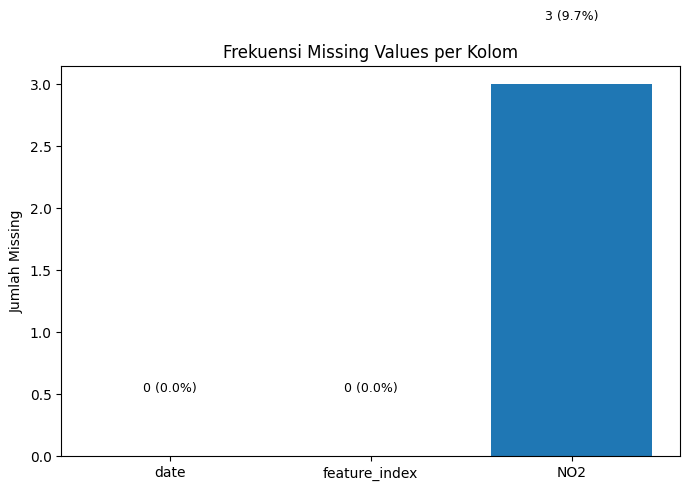

,Missing Count,Missing Percent (%)
date,0,0.00
feature_index,0,0.00
NO2,3,9.68


In [28]:
missing_count = new_df.isnull().sum()
missing_percent = (missing_count / len(df)) * 100

fig, ax = plt.subplots(figsize=(7,5))

bars = ax.bar(missing_count.index, missing_count)

ax.set_title("Frekuensi Missing Values per Kolom")
ax.set_ylabel("Jumlah Missing")

for i, v in enumerate(missing_count):
    ax.text(i, v + 0.5, f"{v} ({missing_percent[i]:.1f}%)",
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

missing_table = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent (%)': missing_percent.round(2)
})

missing_table

Terlihat pada data yang sudah didapatkan, terdapat 3 missing value

#### **Statistik Data**

In [33]:
desc = new_df.describe()
desc

,feature_index,NO2
count,31.0,31.000000
mean,0.0,0.000079
std,0.0,0.000047
min,0.0,0.000019
25%,0.0,0.000052
50%,0.0,0.000066
75%,0.0,0.000095
max,0.0,0.000261


* Jumlah data yang valid (ada 31 hari pengamatan).
* Jumlah data yang valid (ada 31 hari pengamatan).
* Jumlah data yang valid (ada 31 hari pengamatan).
* Jumlah data yang valid (ada 31 hari pengamatan).
* Jumlah data yang valid (ada 31 hari pengamatan).
* Jumlah data yang valid (ada 31 hari pengamatan).
* Jumlah data yang valid (ada 31 hari pengamatan).
* Jumlah data yang valid (ada 31 hari pengamatan).

## **Prepocessing Data**

### **Penanganan Missing Value**

Missing value pada data NO₂ ditangani menggunakan metode interpolasi linier dan pengisian berantai (backward dan forward fill).

Pertama, dilakukan interpolasi linier untuk memperkirakan nilai yang hilang di antara dua data yang masih valid berdasarkan kecenderungan garis lurus. Langkah ini menjaga kontinuitas perubahan nilai harian tanpa mengubah pola tren aslinya.

Setelah itu, jika masih terdapat nilai kosong di awal atau akhir data, dilakukan pengisian nilai terdekat menggunakan metode backward fill (mengisi dengan nilai setelahnya) dan forward fill (mengisi dengan nilai sebelumnya).

In [36]:
new_df['NO2'] = new_df['NO2'].interpolate(method='linear')
new_df['NO2'] = new_df['NO2'].fillna(method='bfill').fillna(method='ffill')



/tmp/ipython-input-3842364359.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_df['NO2'] = new_df['NO2'].fillna(method='bfill').fillna(method='ffill')


Tampilkan Data

In [37]:
info_table = pd.DataFrame({
    "Kolom": new_df.columns,
    "Tipe Data": new_df.dtypes.astype(str),
    "Jumlah Data Tidak Kosong": len(new_df) - new_df.isna().sum(),
    "Jumlah Missing": new_df.isna().sum()
})
info_table

,Kolom,Tipe Data,Jumlah Data Tidak Kosong,Jumlah Missing
date,date,object,31,0
feature_index,feature_index,int64,31,0
NO2,NO2,float64,31,0


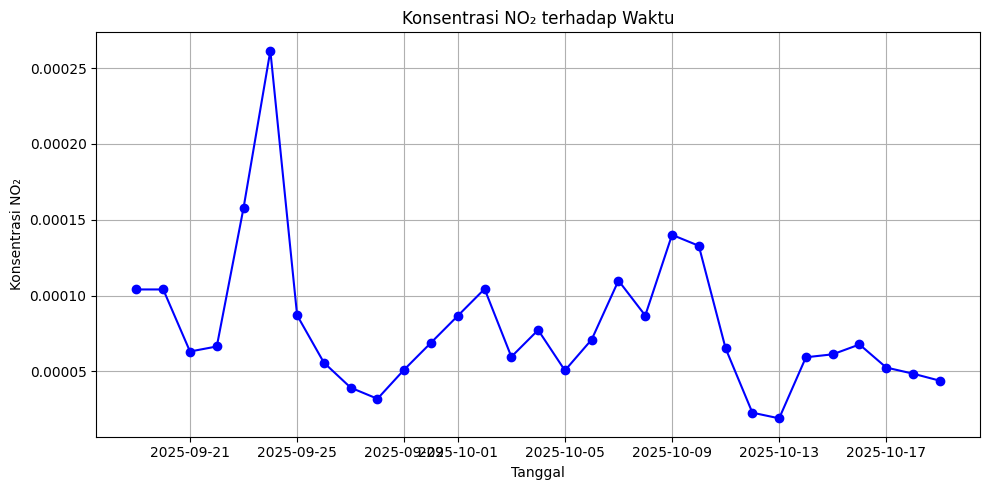

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(new_df['date'], new_df['NO2'], marker='o', linestyle='-', color='blue')
plt.title("Konsentrasi NO₂ terhadap Waktu")
plt.xlabel("Tanggal")
plt.ylabel("Konsentrasi NO₂")
plt.grid(True)
plt.tight_layout()
plt.show()

Grafik yang kamu tampilkan menunjukkan perubahan konsentrasi gas *NO₂* (Nitrogen Dioksida) terhadap waktu di wilayah **Gresik** selama periode **20 September – 20 Oktober 2025.**

### Hasil Grafik

1. Fluktuasi yang jelas antar hari
Terlihat bahwa kadar NO₂ naik-turun cukup tajam, menandakan bahwa polusi udara di wilayah Gresik berubah secara signifikan dari hari ke hari — kemungkinan dipengaruhi oleh faktor cuaca (hujan, arah angin) atau aktivitas industri.

1. Puncak tertinggi sekitar 24–25 September 2025
Nilai NO₂ mencapai puncaknya (sekitar 0.00025 mol/m²) pada tanggal tersebut.
Ini bisa menandakan:

    * Aktivitas industri atau lalu lintas yang meningkat, atau

    * Kondisi atmosfer (misalnya cuaca stabil tanpa hujan) yang menyebabkan akumulasi polutan.

3. Penurunan tajam setelah puncak
Setelah tanggal 25 September, kadar NO₂ turun drastis — kemungkinan karena curah hujan atau angin kuat yang menyebarkan polutan.

4. Periode stabil di awal Oktober
Sekitar 1–10 Oktober terlihat fluktuasi ringan dengan pola relatif stabil di kisaran 0.00005 – 0.00015 mol/m².
Ini menandakan udara lebih bersih dibandingkan akhir September.

5. Fluktuasi kecil di pertengahan Oktober
Menjelang pertengahan bulan (10–17 Oktober), konsentrasi NO₂ sedikit meningkat lalu turun kembali, menandakan aktivitas polutan yang sedang-sedang saja.

## **Pengubahan Data Menjadi Supervised Learning**

Karena model hanya butuh nilai angka (NO2) tanpa informasi tanggal, kolom date dihapus agar dataset berisi nilai konsentrasi saja.

langkah ini dilakukan dengan menggeser (lagging) data historis untuk membuat hubungan antara nilai-nilai masa lalu dan nilai masa kini. Artinya, kita mengubah satu kolom data deret waktu — misalnya kolom NO2 — menjadi format input-output.

Dalam bentuk sederhananya:

Nilai-nilai dari beberapa hari sebelumnya (t-1, t-2, t-3, dst.) dijadikan sebagai fitur (X)

Nilai hari ini (t) dijadikan sebagai target (y) yang akan diprediksi

In [40]:
day2 = new_df
day3 = new_df
day4 = new_df
day5 = new_df

In [41]:
day2 = day2.drop(columns=['date'])
n = 2

for i in range(1, n + 1):
    names = f"t{i}"
    day2[names] = day2['NO2'].shift(i)

day2 = day2.dropna().reset_index(drop=True)
day2

,feature_index,NO2,t1,t2
0,0,0.000063,0.000104,0.000104
1,0,0.000066,0.000063,0.000104
2,0,0.000158,0.000066,0.000063
3,0,0.000261,0.000158,0.000066
4,0,0.000087,0.000261,0.000158
5,0,0.000056,0.000087,0.000261
6,0,0.000039,0.000056,0.000087
7,0,0.000032,0.000039,0.000056
8,0,0.000051,0.000032,0.000039
9,0,0.000069,0.000051,0.000032


In [42]:
day3 = day3.drop(columns=['date'])
n = 3

for i in range(1, n + 1):
    names = f"t{i}"
    day3[names] = day3['NO2'].shift(i)

day3 = day3.dropna().reset_index(drop=True)
day3

,feature_index,NO2,t1,t2,t3
0,0,0.000066,0.000063,0.000104,0.000104
1,0,0.000158,0.000066,0.000063,0.000104
2,0,0.000261,0.000158,0.000066,0.000063
3,0,0.000087,0.000261,0.000158,0.000066
4,0,0.000056,0.000087,0.000261,0.000158
5,0,0.000039,0.000056,0.000087,0.000261
6,0,0.000032,0.000039,0.000056,0.000087
7,0,0.000051,0.000032,0.000039,0.000056
8,0,0.000069,0.000051,0.000032,0.000039
9,0,0.000087,0.000069,0.000051,0.000032


In [43]:
day4 = day4.drop(columns=['date'])
n = 4

for i in range(1, n + 1):
    names = f"t{i}"
    day4[names] = day4['NO2'].shift(i)

day4 = day4.dropna().reset_index(drop=True)
day4

,feature_index,NO2,t1,t2,t3,t4
0,0,0.000158,0.000066,0.000063,0.000104,0.000104
1,0,0.000261,0.000158,0.000066,0.000063,0.000104
2,0,0.000087,0.000261,0.000158,0.000066,0.000063
3,0,0.000056,0.000087,0.000261,0.000158,0.000066
4,0,0.000039,0.000056,0.000087,0.000261,0.000158
5,0,0.000032,0.000039,0.000056,0.000087,0.000261
6,0,0.000051,0.000032,0.000039,0.000056,0.000087
7,0,0.000069,0.000051,0.000032,0.000039,0.000056
8,0,0.000087,0.000069,0.000051,0.000032,0.000039
9,0,0.000104,0.000087,0.000069,0.000051,0.000032


In [44]:
day5 = day5.drop(columns=['date'])
# new_df
n = 5

for i in range(1, n + 1):
    names = f"t{i}"
    day5[names] = day5['NO2'].shift(i)

day5 = day5.dropna().reset_index(drop=True)
day5

,feature_index,NO2,t1,t2,t3,t4,t5
0,0,0.000261,0.000158,0.000066,0.000063,0.000104,0.000104
1,0,0.000087,0.000261,0.000158,0.000066,0.000063,0.000104
2,0,0.000056,0.000087,0.000261,0.000158,0.000066,0.000063
3,0,0.000039,0.000056,0.000087,0.000261,0.000158,0.000066
4,0,0.000032,0.000039,0.000056,0.000087,0.000261,0.000158
5,0,0.000051,0.000032,0.000039,0.000056,0.000087,0.000261
6,0,0.000069,0.000051,0.000032,0.000039,0.000056,0.000087
7,0,0.000087,0.000069,0.000051,0.000032,0.000039,0.000056
8,0,0.000104,0.000087,0.000069,0.000051,0.000032,0.000039
9,0,0.000060,0.000104,0.000087,0.000069,0.000051,0.000032


## **Modelling**

modelling dilakukan untuk memprediksi kadar gas Nitrogen Dioksida (NO₂) di wilayah Gresik berdasarkan data 30 hari hasil pengamatan satelit Sentinel-5P.
Tujuan utamanya adalah melihat apakah data kadar NO₂ beberapa hari sebelumnya dapat digunakan untuk memperkirakan kadar NO₂ hari berikutnya.

Model yang digunakan adalah K-Nearest Neighbors Regression (KNN Regression).
KNN bekerja dengan cara mencari sejumlah titik data (tetangga terdekat) yang paling mirip dengan data yang ingin diprediksi, kemudian menghitung rata-ratanya untuk menghasilkan nilai prediksi.

### **Tujuan Modelling Lag n Day**

Untuk mengetahui berapa hari sebelumnya (lag) yang paling berpengaruh dalam memprediksi kadar NO₂ hari ini, dibuat beberapa model dengan variasi jumlah hari sebelumnya:

* Lag 2 Hari (day2) → menggunakan data 2 hari terakhir untuk memprediksi hari ke-3

* Lag 3 Hari (day3) → menggunakan data 3 hari terakhir untuk memprediksi hari ke-4

* Lag 4 Hari (day4) → menggunakan data 4 hari terakhir untuk memprediksi hari ke-5

* Lag 5 Hari (day5) → menggunakan data 5 hari terakhir untuk memprediksi hari ke-6

Setiap model dievaluasi menggunakan dua metrik:

* Mean Squared Error (MSE) → mengukur rata-rata kesalahan prediksi.

* R² (R-squared) → menunjukkan seberapa baik model menjelaskan variasi data aktual.

### **Modeling Forecasting dengan Lag 2 Hari**

In [45]:
X = day2.drop(columns=['NO2'])
y = day2['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
day2_predict = knn.predict(X_test_scaled)
r2_day2 = r2_score(y_test, day2_predict)
mse_day2 = mean_squared_error(y_test, day2_predict)

print("MSE:", mse_day2)
print("R2:", r2_day2)

MSE: 8.07299873047843e-10
R2: -0.08798093694835885


### **Modeling Forecasting dengan Lag 3 Hari**

In [46]:
X = day3.drop(columns=['NO2'])
y = day3['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
day3_predict = knn.predict(X_test_scaled)
r2_day3 = r2_score(y_test, day3_predict)
mse_day3 = mean_squared_error(y_test, day3_predict)

print("MSE:", mse_day3)
print("R2:", r2_day3)

MSE: 9.207340084977446e-10
R2: -0.943074737599265


### **Modeling Forecasting dengan Lag 4 Hari**

In [47]:
X = day4.drop(columns=['NO2'])
y = day4['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
day4_predict = knn.predict(X_test_scaled)
r2_day4 = r2_score(y_test, day4_predict)
mse_day4 = mean_squared_error(y_test, day4_predict)

print("MSE:", mse_day4)
print("R2:", r2_day4)

MSE: 2.1688795718579647e-09
R2: -1.0842952774629508


### **Modeling Forecasting dengan Lag 5 Hari**

In [48]:
X = day5.drop(columns=['NO2'])
y = day5['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
day5_predict = knn.predict(X_test_scaled)
r2_day5 = r2_score(y_test, day5_predict)
mse_day5 = mean_squared_error(y_test, day5_predict)

print("MSE:", mse_day5)
print("R2:", r2_day5)

MSE: 5.406320198744392e-09
R2: 0.026833612301711218


## **Perbandingan Performa Model (Nilai R² Tiap Lag Hari)**

* Variabel x berisi label jumlah hari sebelumnya (2, 3, 4, dan 5 hari).

* Variabel y berisi nilai R² dari masing-masing model (hasil evaluasi).

* Kemudian dibuat grafik batang (bar chart) untuk memvisualisasikan perbandingan nilai R² antar model.

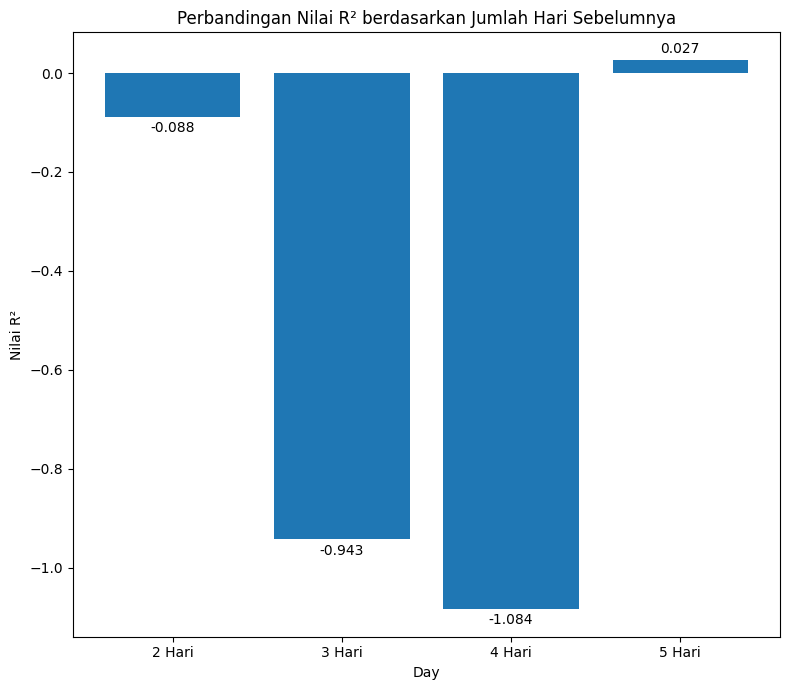

In [49]:
x = ['2 Hari', '3 Hari', '4 Hari', '5 Hari']
y = [r2_day2, r2_day3, r2_day4, r2_day5]

fig, ax = plt.subplots(figsize=(8, 7))
bars = ax.bar(x, y)

ax.set_title("Perbandingan Nilai R² berdasarkan Jumlah Hari Sebelumnya")
ax.set_xlabel("Day")
ax.set_ylabel("Nilai R²")

ax.bar_label(bars, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

### **Hasil Grafik**

* Sumbu X (horizontal) menunjukkan jumlah hari sebelumnya (lag) yang digunakan dalam model: 2 hari, 3 hari, 4 hari, dan 5 hari.

* Sumbu Y (vertikal) menunjukkan nilai R² (koefisien determinasi), yaitu ukuran seberapa baik model menjelaskan variasi data aktual.

* Semakin tinggi nilai R² (mendekati 1), semakin baik model dalam memprediksi nilai aktual.

* Nilai R² yang negatif berarti model lebih buruk daripada baseline (rata-rata data), atau dengan kata lain, prediksi model tidak mencerminkan pola data sebenarnya.

## **Evaluasi**

Berdasarkan hasil evaluasi:

* Semua nilai R² berada di sekitar 0 atau negatif, menandakan bahwa model KNN belum mampu menangkap hubungan kuat antara kadar NO₂ hari-hari sebelumnya dengan hari berikutnya.

* Nilai MSE (Mean Squared Error) yang besar dan R² negatif menunjukkan bahwa fluktuasi kadar NO₂ bersifat acak atau dipengaruhi faktor eksternal (seperti cuaca, arah angin, atau aktivitas industri) yang tidak tercermin dalam data historis harian.

* Menambah jumlah lag hari (dari 2 hingga 5) tidak memperbaiki performa model, bahkan memperburuk karena menambah variabel yang tidak relevan untuk dataset kecil.